In [ ]:
!pip install einops


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 583 kB/s 


In [ ]:
import torch
import torch.nn as nn

In [ ]:
import numpy as np
from einops import rearrange, repeat


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, head_num):
        super().__init__()

        self.head_num = head_num
        self.dk = (embedding_dim // head_num) ** 1 / 2

        self.qkv_layer = nn.Linear(embedding_dim, embedding_dim * 3, bias=False)
        self.out_attention = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x, mask=None):
        qkv = self.qkv_layer(x)

        query, key, value = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.head_num))
        energy = torch.einsum("... i d , ... j d -> ... i j", query, key) * self.dk

        if mask is not None:
            energy = energy.masked_fill(mask, -np.inf)

        attention = torch.softmax(energy, dim=-1)

        x = torch.einsum("... i j , ... j d -> ... i d", attention, value)

        x = rearrange(x, "b h t d -> b t (h d)")
        x = self.out_attention(x)

        return x


class MLP(nn.Module):
    def __init__(self, embedding_dim, mlp_dim):
        super().__init__()

        self.mlp_layers = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_dim, embedding_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = self.mlp_layers(x)

        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim):
        super().__init__()

        self.multi_head_attention = MultiHeadAttention(embedding_dim, head_num)
        self.mlp = MLP(embedding_dim, mlp_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        _x = self.multi_head_attention(x)
        _x = self.dropout(_x)
        x = x + _x
        x = self.layer_norm1(x)

        _x = self.mlp(x)
        x = x + _x
        x = self.layer_norm2(x)

        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim, block_num=12):
        super().__init__()

        self.layer_blocks = nn.ModuleList(
            [TransformerEncoderBlock(embedding_dim, head_num, mlp_dim) for _ in range(block_num)])

    def forward(self, x):
        for layer_block in self.layer_blocks:
            x = layer_block(x)

        return x


class ViT(nn.Module):
    def __init__(self, img_dim, in_channels, embedding_dim, head_num, mlp_dim,
                 block_num, patch_dim, classification=True, num_classes=1):
        super().__init__()

        self.patch_dim = patch_dim
        self.classification = classification
        self.num_tokens = (img_dim // patch_dim) ** 2
        self.token_dim = in_channels * (patch_dim ** 2)

        self.projection = nn.Linear(self.token_dim, embedding_dim)
        self.embedding = nn.Parameter(torch.rand(self.num_tokens + 1, embedding_dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.dropout = nn.Dropout(0.1)

        self.transformer = TransformerEncoder(embedding_dim, head_num, mlp_dim, block_num)

        if self.classification:
            self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        img_patches = rearrange(x,
                                'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_dim, patch_y=self.patch_dim)

        batch_size, tokens, _ = img_patches.shape

        project = self.projection(img_patches)
        token = repeat(self.cls_token, 'b ... -> (b batch_size) ...',
                       batch_size=batch_size)

        patches = torch.cat([token, project], dim=1)
        patches += self.embedding[:tokens + 1, :]

        x = self.dropout(patches)
        x = self.transformer(x)
        x = self.mlp_head(x[:, 0, :]) if self.classification else x[:, 1:, :]

        return x

In [ ]:
vit = ViT(img_dim=128,
              in_channels=3,
              patch_dim=16,
              embedding_dim=512,
              block_num=6,
              head_num=4,
              mlp_dim=1024)

In [ ]:
class EncoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, base_width=64):
        super().__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        width = int(out_channels * (base_width / 64))

        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, stride=1, bias=False)
        self.norm1 = nn.BatchNorm2d(width)

        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=2, groups=1, padding=1, dilation=1, bias=False)
        self.norm2 = nn.BatchNorm2d(width)

        self.conv3 = nn.Conv2d(width, out_channels, kernel_size=1, stride=1, bias=False)
        self.norm3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x_down = self.downsample(x)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = x + x_down
        x = self.relu(x)

        return x

In [ ]:
class DecoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, x_concat=None):
        x = self.upsample(x)

        if x_concat is not None:
            x = torch.cat([x_concat, x], dim=1)

        x = self.layer(x)
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.encoder1 = EncoderBottleneck(out_channels, out_channels * 2, stride=2)
        self.encoder2 = EncoderBottleneck(out_channels * 2, out_channels * 4, stride=2)
        self.encoder3 = EncoderBottleneck(out_channels * 4, out_channels * 8, stride=2)

        self.vit_img_dim = img_dim // patch_dim
        self.vit = ViT(self.vit_img_dim, out_channels * 8, out_channels * 8,
                       head_num, mlp_dim, block_num, patch_dim=1, classification=False)

        self.conv2 = nn.Conv2d(out_channels * 8, 512, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x1 = self.relu(x)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x = self.encoder3(x3)

        x = self.vit(x)
        x = rearrange(x, "b (x y) c -> b c x y", x=self.vit_img_dim, y=self.vit_img_dim)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        return x, x1, x2, x3

In [ ]:
class Decoder(nn.Module):
    def __init__(self, out_channels, class_num):
        super().__init__()

        self.decoder1 = DecoderBottleneck(out_channels * 8, out_channels * 2)
        self.decoder2 = DecoderBottleneck(out_channels * 4, out_channels)
        self.decoder3 = DecoderBottleneck(out_channels * 2, int(out_channels * 1 / 2))
        self.decoder4 = DecoderBottleneck(int(out_channels * 1 / 2), int(out_channels * 1 / 8))

        self.conv1 = nn.Conv2d(int(out_channels * 1 / 8), class_num, kernel_size=1)

    def forward(self, x, x1, x2, x3):
        x = self.decoder1(x, x3)
        x = self.decoder2(x, x2)
        x = self.decoder3(x, x1)
        x = self.decoder4(x)
        x = self.conv1(x)

        return x

In [ ]:
class TransUNet(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim, class_num):
        super().__init__()

        self.encoder = Encoder(img_dim, in_channels, out_channels,
                               head_num, mlp_dim, block_num, patch_dim)

        self.decoder = Decoder(out_channels, class_num)

    def forward(self, x):
        x, x1, x2, x3 = self.encoder(x)
        x = self.decoder(x, x1, x2, x3)

        return x

In [ ]:
transunet = TransUNet(img_dim=128,
                          in_channels=1,
                          out_channels=128,
                          head_num=4,
                          mlp_dim=512,
                          block_num=8,
                          patch_dim=16,
                          class_num=1).cuda()

In [ ]:
print(sum(p.numel() for p in transunet.parameters()))
#print(transunet(torch.randn(1, 1, 128, 128)).shape)

66870129


In [ ]:
from IPython.core.display import display, HTML
from string import Template
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from torch.utils.data import DataLoader,Dataset
import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

In [ ]:
import tqdm

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
df = pd.read_csv(path + 'media/train.csv')

In [ ]:
df.head()

,id,name,label,attributes,points,image
0,16,Cr1,9,1,"[[189,308],[188,306],[188,305],[187,303],[187,...",/media/category_52/000078.jpg
1,17,Cr1,9,2,"[[154,303],[154,301],[154,299],[154,297],[154,...",/media/category_52/000079.jpg
2,18,Cr1,9,3,"[[197,319],[194,320],[193,321],[193,323],[193,...",/media/category_52/000080.jpg
3,20,Cr1,9,4,"[[193,329],[196,328],[198,327],[201,326],[203,...",/media/category_52/000081.jpg
4,21,Cr1,9,5,"[[150,283],[152,282],[154,281],[154,280],[156,...",/media/category_52/000082.jpg


In [ ]:
df['name'].unique()

array(['Cr1', 'Cr2', 'Cr3', 'Cr4', 'Cr5', 'Cr6', 'Cr7', 'Cr8', 'Cr9',
       'Cr10', 'large cell carcinoma', 'adenocarcinoma',
       'non-small-cell lung carcinoma', 'squamous cell carcinoma'],
      dtype=object)

In [ ]:
df = df.replace(to_replace =['Cr1', 'Cr2', 'Cr3', 'Cr4', 'Cr5', 'Cr6', 'Cr7', 'Cr8', 'Cr9',
       'Cr10'], value ='adenocarcinoma')

In [ ]:
num = df['name'].unique()

In [ ]:
df

,id,name,label,attributes,points,image
0,16,adenocarcinoma,9,1,"[[189,308],[188,306],[188,305],[187,303],[187,...",/media/category_52/000078.jpg
1,17,adenocarcinoma,9,2,"[[154,303],[154,301],[154,299],[154,297],[154,...",/media/category_52/000079.jpg
2,18,adenocarcinoma,9,3,"[[197,319],[194,320],[193,321],[193,323],[193,...",/media/category_52/000080.jpg
3,20,adenocarcinoma,9,4,"[[193,329],[196,328],[198,327],[201,326],[203,...",/media/category_52/000081.jpg
4,21,adenocarcinoma,9,5,"[[150,283],[152,282],[154,281],[154,280],[156,...",/media/category_52/000082.jpg
...,...,...,...,...,...,...
529,616,adenocarcinoma,20,1,"[[159,347],[163,345],[164,344],[165,343],[167,...",/media/category_153/000033.jpg
530,617,adenocarcinoma,20,2,"[[166,329],[171,325],[175,325],[175,324],[177,...",/media/category_153/000034.jpg
531,618,adenocarcinoma,20,3,"[[184,340],[184,336],[184,332],[185,330],[188,...",/media/category_153/000035.jpg
532,619,adenocarcinoma,20,4,"[[161,344],[165,342],[168,341],[168,340],[174,...",/media/category_153/000036.jpg


In [ ]:
df1 = df
for i in range(len(df['name'])):
    for j in range(len(num)):
        if df['name'][i] == num[j]:
            df1['name'][i] = j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#change string to np array
df['points'] = df['points'].apply(lambda x: np.array(eval(x)), 0)

In [ ]:
dfnew = []

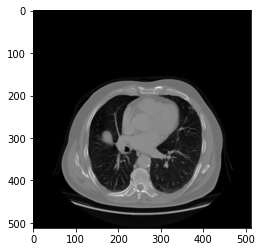

In [ ]:
origImage = cv2.imread(path  + df['image'][0])
origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
plt.imshow(origImage,cmap = "gray")

In [ ]:
from tqdm import tqdm
from matplotlib.path import Path
ar = []
for ind in tqdm(range(len(df['image']))):
    tupVerts= df['points'][ind]


    x, y = np.meshgrid(np.arange(origImage.shape[0]), np.arange(origImage.shape[1])) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(tupVerts) # make a polygon
    grid = p.contains_points(points)
    mask = (grid.reshape(origImage.shape[0],origImage.shape[0])*1).astype('float32') # now you have a mask with points inside a polygon
    mask = cv2.resize(mask, (128,128))
    #mask = grid.reshape(origImage.shape[0],origImage.shape[0])*1
    #mask = grid.reshape([128,128])*1 
    #mask = cv2.resize(mask, (128, 128))
    ar.append(mask)
df['mask'] = ar

100%|██████████| 534/534 [00:28<00:00, 18.64it/s]


In [ ]:
mask.shape

(128, 128)

In [ ]:
origImage.shape[0]

512

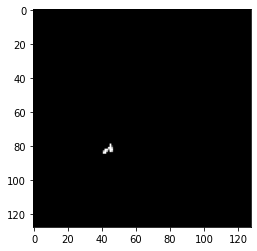

In [ ]:
plt.imshow((mask),cmap = "gray")

In [ ]:
ar = []
for ind in tqdm(range(len(df['image']))):
    origImage = cv2.imread(path  + df['image'][ind])
    origImage = cv2.resize(origImage, (128, 128))
    origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    ar.append(origImage)
df['img'] = ar

100%|██████████| 534/534 [08:56<00:00,  1.00s/it]


In [ ]:
origImage.shape

(128, 128)

In [ ]:
x = []
y = []
z = []
for ind in tqdm(range(len(df))):
    x.append(df['img'][ind])
    y.append(df['mask'][ind])
    z.append(df['name'][ind])

100%|██████████| 534/534 [00:00<00:00, 46494.06it/s]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2, random_state=10)

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
class MyDataset(Dataset):
    def __init__(self, data, targets, label, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.label = label
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        z = self.label[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y, z

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, z_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, z_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  del sys.path[0]


In [ ]:
cnt = 0
temp = 0
for i, batch in enumerate(tqdm(trainloader)):
        X_batch, y_batch, z_batch = batch
        cnt = i
        if i % 2000 == 1999:
            temp += 1 
cnt,temp

100%|██████████| 107/107 [00:00<00:00, 1071.73it/s]


(106, 0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def dice_loss(pred, target):
    pred = torch.sigmoid(pred)

    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = torch.sum(pred * target)
    pred_sum = torch.sum(pred * pred)
    target_sum = torch.sum(target * target)

    return 1 - ((2. * intersection + 1e-5) / (pred_sum + target_sum + 1e-5))

In [ ]:
!pip install easydict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim import SGD
# loss function
#criterion = nn.CrossEntropyLoss()
criterion = dice_loss
optimizer = SGD(transunet.parameters(), lr=1e-1,
                    momentum=0.9, weight_decay=1e-4)
# optimizer
#optimizer = optim.Adam(transunet.parameters(), lr=0.01)

In [ ]:
error = []
test_error = []
for epoch in range(100):        
        for ind, batch in enumerate(trainloader):
          imgs, true_masks, label= batch
          images = imgs
          images = images.to(device=device, dtype=torch.float32)
          #print(images.shape)
          label = label.to(device = device, dtype = torch.long)
          true_masks = true_masks.to(device=device, dtype=torch.float32)
          output = transunet(images)
          #print(output)
          output = torch.squeeze(output,1)
          #print(output)
          output = output.to(device=device, dtype=torch.float32)
          loss = criterion(output.squeeze(0), true_masks.squeeze(0))
          #if (epoch%10 == 0):
          #print(ind)
          if(ind ==0): 
              error.append(loss.item())   
              print(epoch, ' ',loss.item())

          optimizer.zero_grad()
          loss.backward() 
          optimizer.step()
            
          

0   0.9837183952331543
1   0.7213104963302612
2   0.6404238939285278
3   0.6902601718902588
4   0.6527306437492371
5   0.67113196849823
6   0.6901916265487671
7   0.7355104684829712
8   0.6020902395248413
9   0.6109170913696289
10   0.6226093769073486
11   0.513863205909729
12   0.5571844577789307
13   0.47299158573150635
14   0.414201021194458
15   0.5271323919296265
16   0.5063531994819641
17   0.4450368285179138
18   0.4855567216873169
19   0.3770337700843811
20   0.4699559807777405
21   0.43208515644073486
22   0.3086833357810974
23   0.36097609996795654
24   0.34960854053497314
25   0.3064148426055908
26   0.2940865159034729
27   0.3085557222366333
28   0.553036093711853
29   0.2750530242919922
30   0.39344358444213867
31   0.3060908317565918
32   0.29437100887298584
33   0.31148064136505127
34   0.2830502390861511
35   0.2699914574623108
36   0.3117321729660034
37   0.31316882371902466
38   0.2527438998222351
39   0.28287333250045776
40   0.268560528755188
41   0.2683144807815552

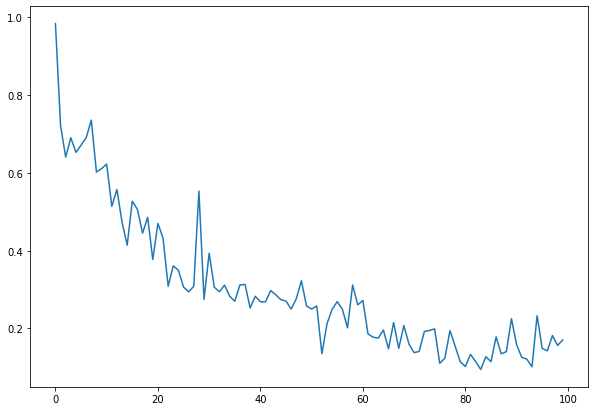

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(error)), error)
plt.plot(np.arange(len(test_error)), test_error)
plt.show()

In [ ]:
predicted = []
with torch.no_grad():
    for data in tqdm(testloader):
        img_np, mask, label = data
        img = img_np.to(device=device, dtype=torch.float32)
        output = transunet(img)
        output = torch.sigmoid(torch.squeeze(output,1))
        full_mask = output.cpu().numpy()
        predicted.append([img_np, (full_mask >0.5)*1, mask, label])

100%|██████████| 27/27 [00:00<00:00, 41.74it/s]


In [ ]:
np.array(predicted).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(27, 4)

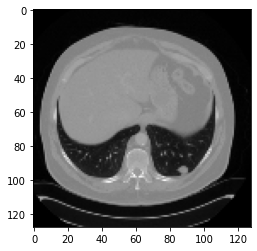

In [ ]:
plt.imshow(predicted[10][0][0][0].numpy(),cmap = "gray")

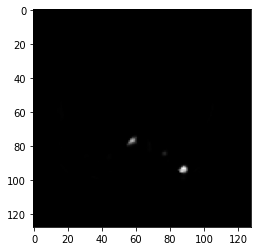

In [ ]:
plt.imshow((predicted[10][1][0]*1),cmap = "gray")

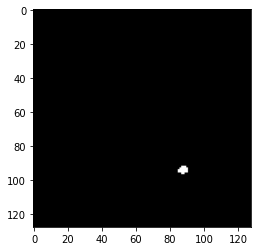

In [ ]:
plt.imshow((predicted[10][2][0]),cmap = "gray")

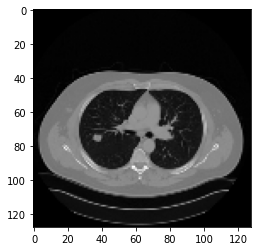

In [ ]:
plt.imshow(predicted[1][0][0][0].numpy(),cmap = "gray")

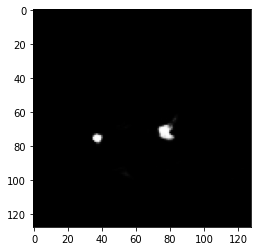

In [ ]:
plt.imshow((predicted[1][1][0]*1),cmap = "gray")

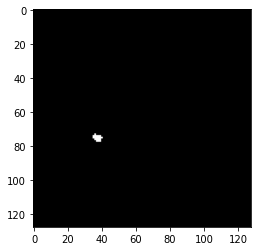

In [ ]:
plt.imshow((predicted[1][2][0]),cmap = "gray")

In [ ]:
def dice_coeff(pred, target):
    m1 = np.array(pred).flatten()
    m2 = np.array(target).flatten()
    #smooth = 1.
    #num = pred.size(0)
    #m1 = pred.view(num, -1).float()  # Flatten
    #m2 = target.view(num, -1).float()  # Flatten
    intersection = np.sum(m1 * m2)

    return (2. * intersection ) / (m1.sum() + m2.sum() )

In [ ]:
predicted[i][2][0]

IndexError: ignored

In [ ]:
dices = []
for i in range(len(predicted)):
  dices.append(dice_coeff(predicted[i][1][0]*1, predicted[i][2][0]))

In [ ]:
np.mean(dices)

0.5072689811914932

In [ ]:
dice_coeff(predicted[10][1][0]*1, predicted[10][2][0])

0.4082965731783615

In [ ]:
dice_coeff(predicted[1][1][0]*1, predicted[1][2][0])

0.32305219711003086

In [ ]:
for i in range(10):
    predicted = []
    with torch.no_grad():
        for data in tqdm(testloader):
            img_np, mask, label = data
            img = img_np.to(device=device, dtype=torch.float32)
            output = transunet(img)
            output = torch.sigmoid(torch.squeeze(output,1))
            full_mask = output.cpu().numpy()
            predicted.append([img_np, (full_mask >i/10)*1, mask, label])
    dices = []
    for j in range(len(predicted)):
        dices.append(dice_coeff(predicted[j][1][0]*1, predicted[j][2][0]))
    print(i/10, ' ', np.mean(dices))
    

100%|██████████| 27/27 [00:00<00:00, 37.61it/s]


0.0   0.008427143610090386


100%|██████████| 27/27 [00:00<00:00, 41.33it/s]


0.1   0.5969756386288284


100%|██████████| 27/27 [00:00<00:00, 41.56it/s]


0.2   0.6168603174912894


100%|██████████| 27/27 [00:00<00:00, 40.89it/s]


0.3   0.6107605198791476


100%|██████████| 27/27 [00:00<00:00, 41.43it/s]


0.4   0.5950677164949236


100%|██████████| 27/27 [00:00<00:00, 40.77it/s]


0.5   0.5872189113553842


100%|██████████| 27/27 [00:00<00:00, 41.13it/s]


0.6   0.5789736582679469


100%|██████████| 27/27 [00:00<00:00, 40.98it/s]


0.7   0.5642403838617662


100%|██████████| 27/27 [00:00<00:00, 41.06it/s]


0.8   0.5376986859508562


100%|██████████| 27/27 [00:00<00:00, 40.86it/s]

0.9   0.48169438069986625
